In [2]:
import csv
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [15, 15]
from tqdm import tqdm_notebook
import random
import numpy as np

In [3]:
def read_points(dataset_name, y_col_number):
    x = []
    y = []
    with open (dataset_name, 'r') as fin:
        csvReader = csv.reader(fin, delimiter=',')
        for row in csvReader:
            if csvReader.line_num != 1:
                float_row = []
                for i in range(0, len(row)):
                    if i != y_col_number:
                        float_row.append(float(row[i]))
                x.append(float_row)
                y.append(float(row[y_col_number]))
    return x, y

In [4]:
def split(x, y):
    test_indexes = random.sample(range(len(x)), len(x) // 5)
    train_indexes = set([i for i in range(len(x))]) - set(test_indexes)
    return [x[i] for i in train_indexes], [y[i] for i in train_indexes], [x[i] for i in test_indexes], [y[i] for i in test_indexes]

In [5]:
def get_w(x, y, alpha):
    if (np.linalg.det(np.dot(x.transpose(), x))):
        return np.dot(np.dot(np.linalg.inv(np.dot(x.transpose(), x) + alpha * np.identity(len(x[0]))), x.transpose()), y)
    return 0

In [6]:
def draw_point(x, y, color, size=10):
    plt.scatter(x, y, size, color)

In [7]:
def add_degree(x, degree):
    new_x = []
    for elem in x:
        new_x.append(elem[:])
    if len(new_x[0]) == 1:
        for j in range(len(new_x)):
            for i in range(2, degree + 1):
                new_x[j].append(new_x[j][0] ** i)
    else:
        if degree == 2:
            for j in range(len(new_x)):
                ln = len(new_x[j])
                for i in range(ln):
                    for k in range(i, ln):
                        new_x[j].append(new_x[j][i] * new_x[j][k])  
    for i in range(len(new_x)):
        new_x[i] = [1] + new_x[i]   
    return new_x

In [8]:
def r_squared(x, y, h, degree):
    new_x = add_degree(x, degree)
    predicted_y = h.predict(new_x)
    u = 0
    v = 0
    sum_y = np.sum(y)
    for i in range(len(x)):
        u += (predicted_y[i] - y[i]) ** 2
        v += (1.0 / len(x) * sum_y - y[i]) ** 2
    return 1 - 1.0 * u / v

In [9]:
from sklearn import linear_model
def lasso(x, y, degree, alpha):
    new_x = add_degree(x, degree)
    clf = linear_model.Lasso(alpha=alpha)
    clf.fit(new_x, y)
    return clf

In [10]:
def get_alpha(train_x, train_y, test_x, test_y, degree):
    best_clf = None
    best_r1 = None
    best_alpha = None
    for alpha in [0.1 ** 11, 0.1 ** 10, 0.1 ** 9, 0.1 ** 8, 0.1 ** 7, 0.1 ** 6, 0.1 ** 5, 0.1 ** 4, 0.1 ** 3, 0.1 ** 2, 1.0, 10, 10 ** 2, 10 ** 3, 10 ** 4]:
        clf = lasso(train_x, train_y, degree, alpha)
        r1 = r_squared(test_x, test_y, clf, degree)
        if (not best_clf) or (r1 > best_r1):
            best_clf = clf
            best_r1 = r1  
            best_alpha = alpha
    return best_clf, best_alpha

In [11]:
def draw_lasso(dataset_name, label_col_number, draw=False):
    x, y = read_points(dataset_name, label_col_number)
    dataset_name = dataset_name.split("/")[2].split(".")[0]
    
    train_x, train_y, test_x, test_y = split(x, y)
    h1, alpha1 = get_alpha(train_x, train_y, test_x, test_y, 1)
    print(dataset_name + ": degree = 1, alpha = " + str(alpha1) + " R^2 = " + str(r_squared(test_x, test_y, h1, 1)) + ", features number = " + str((h1.coef_ != 0).sum()) + "/" + str(len(h1.coef_)))
    h2, alpha2 = get_alpha(train_x, train_y, test_x, test_y, 2)
    print(dataset_name + ": degree = 2, alpha = " + str(alpha2) + " R^2 = " + str(r_squared(test_x, test_y, h2, 2)) + ", features number = " + str((h2.coef_ != 0).sum()) + "/" + str(len(h2.coef_)))
    
    if (draw):
        h3, alpha3 = get_alpha(train_x, train_y, test_x, test_y, 3)
        print(dataset_name + ": degree = 3, alpha = " + str(alpha3) + " R^2 = " + str(r_squared(test_x, test_y, h3, 3)) + ", features number = " + str((h3.coef_ != 0).sum()) + "/" + str(len(h3.coef_)))
        h4, alpha4 = get_alpha(train_x, train_y, test_x, test_y, 4)
        print(dataset_name + ": degree = 4, alpha = " + str(alpha4) + " R^2 = " + str(r_squared(test_x, test_y, h4, 4)) + ", features number = " + str((h4.coef_ != 0).sum()) + "/" + str(len(h4.coef_)))
        h5, alpha5 = get_alpha(train_x, train_y, test_x, test_y, 5)
        print(dataset_name + ": degree = 5, alpha = " + str(alpha5) + " R^2 = " + str(r_squared(test_x, test_y, h5, 5)) + ", features number = " + str((h5.coef_ != 0).sum()) + "/" + str(len(h5.coef_)))
        plt.plot(np.array(x), h1.predict(np.array(add_degree(x, 1))))
        plt.plot(np.array(x), h2.predict(np.array(add_degree(x, 2))))
        plt.plot(np.array(x), h3.predict(np.array(add_degree(x, 3))))
        plt.plot(np.array(x), h4.predict(np.array(add_degree(x, 4))))
        plt.plot(np.array(x), h5.predict(np.array(add_degree(x, 5))))
        for i in range(len(x)):
            draw_point(x[i][0], y[i], 'black')
        plt.show()

noisysine: degree = 1, alpha = 1e-11 R^2 = 0.4880653541847151, features number = 1/2
noisysine: degree = 2, alpha = 1e-11 R^2 = 0.4798246458004757, features number = 2/3
noisysine: degree = 3, alpha = 0.01 R^2 = 0.42778026346931197, features number = 3/4
noisysine: degree = 4, alpha = 0.01 R^2 = 0.4309680815028958, features number = 4/5
noisysine: degree = 5, alpha = 0.01 R^2 = 0.460236374763058, features number = 5/6


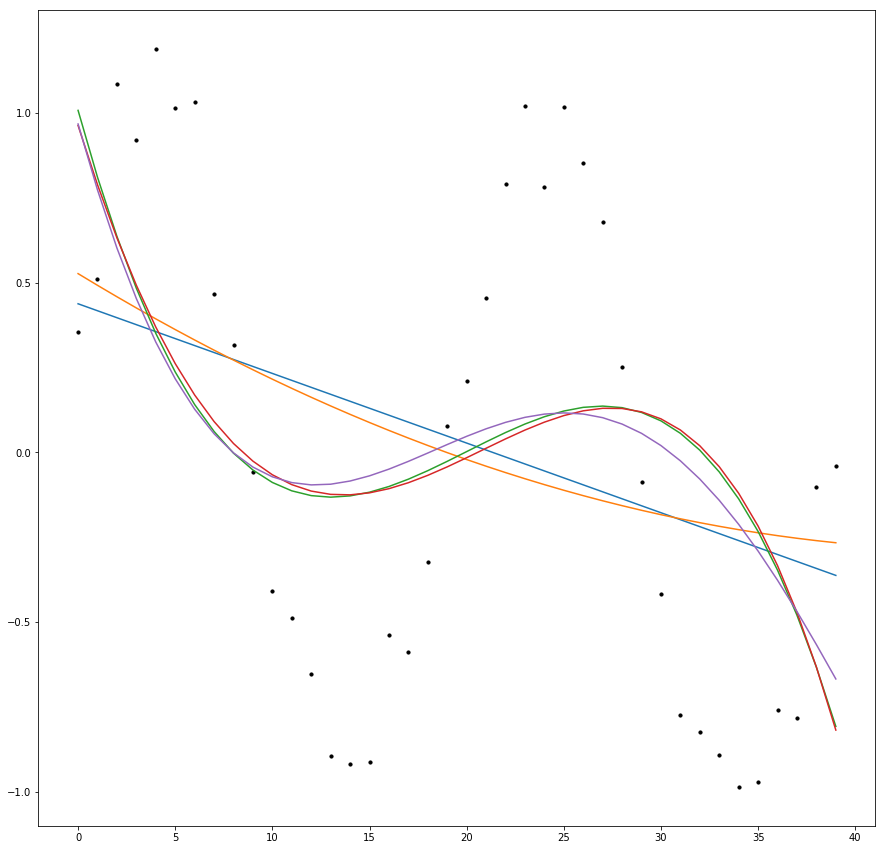

In [15]:
draw_lasso("../Datasets/noisysine.csv", 1, True)

In [16]:
draw_lasso("../Datasets/hydrodynamics.csv", 6)

hydrodynamics: degree = 1, alpha = 0.0001 R^2 = 0.6366273672851398, features number = 6/7
hydrodynamics: degree = 2, alpha = 0.0001 R^2 = 0.9286377859296362, features number = 25/28
